<a href="https://colab.research.google.com/github/walquiria16/BrazilElection/blob/main/valohai_reddit_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get posts and predictions data from S3

In [ ]:
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, classification_report

sns.set_style("dark")

REDDIT_S3_PATH = 'https://valohai-fasttext-example.s3.eu-west-3.amazonaws.com/reddit/'

posts_df = pd.read_csv(REDDIT_S3_PATH + 'reddit_posts_4M.csv')
predictions_df = pd.read_csv(REDDIT_S3_PATH + 'test_predictions.csv')

posts_df['date'] = posts_df['created_utc'].apply(datetime.fromtimestamp)

In [ ]:
posts_df.sample(5).fillna('')[['id', 'title', 'selftext', 'date', 'subreddit_name']]

,id,title,selftext,date,subreddit_name
2879836,ff6qli,Traffic Flow crossing one of four major crossi...,,2020-03-08 03:28:29,CitiesSkylines
2359190,f5vj46,"People in Oregon to need to read this, we have...",,2020-02-18 17:41:29,progun
275280,ey2lat,Taiwan Foreign Affairs Minister going after th...,,2020-02-03 06:11:22,taiwan
512666,eyp7w5,Sea water jammed in sinuses for days after surf,Does anyone ever get it after surfing that all...,2020-02-04 12:18:44,surfing
1314832,elzxqg,Homeless man trespassed and stole tons of stuf...,,2020-01-08 22:18:32,Brunei


In [ ]:
predictions_df.head()

,text,label,label@1,label@2,label@3,label@4,label@5,label@6,label@7,label@8,label@9,label@10,label@11,label@12,label@13,label@14,label@15,label@16,label@17,label@18,label@19,label@20,p@1,p@2,p@3,p@4,p@5,p@6,p@7,p@8,p@9,p@10,p@11,p@12,p@13,p@14,p@15,p@16,p@17,p@18,p@19,p@20,error
0,eternally doom to prrs mk eknowoo cc amb amre...,HFY,MachineLearning,amateurradio,nasa,ffxiv,labrats,AskNetsec,stobuilds,gasmasks,Mcat,IndiaSpeaks,statistics,chernobyl,space,belgium,actuary,india,chemistry,archlinux,bioinformatics,poland,0.022726,0.011084,0.009955,0.009334,0.009090,0.008487,0.007212,0.006198,0.005829,0.005780,0.005611,0.005451,0.005215,0.004942,0.004885,0.004804,0.004771,0.004742,0.004734,0.004671,True
1,best tacos in buffalo so who has the best taco...,Buffalo,Buffalo,Rochester,LasVegas,vegas,fastfood,tacobell,PeakyBlinders,watercooling,BlackClover,europe,egg_irl,Glocks,Cornell,SmashBrosUltimate,Colombia,COMPLETEANARCHY,sjain_guides,motorsportsstreams,FREEMEDIAHECKYEAH,cursedimages,1.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,False
2,ive seen it all at this point ive dealt with a...,dbfz,dragonballfighterz,dbfz,BobsTavern,learndota2,BnHAOnesJustice,OverwatchUniversity,jumpforce,heroesofthestorm,EASportsUFC,CrazyHand,MLBTheShow,FinalFantasyXII,DragonsDogma,Overwatch,GranblueFantasyVersus,INJUSTICE,DivinityOriginalSin,SoulCalibur,summonerschool,CompetitiveForHonor,0.072894,0.058824,0.044579,0.033376,0.023099,0.022649,0.021327,0.020386,0.017889,0.016961,0.016598,0.015636,0.012724,0.012412,0.011027,0.010969,0.010765,0.010226,0.010111,0.009363,True
3,series 6 has begun,PeakyBlinders,smoking,Portal,billsimmons,704nascarheat,originalxbox,cade,Rogers,Rockband,litrpg,saskatoon,NASCAR,breakingbad,barstoolsports,HaggardGarage,hotones,Arcade1Up,swrpg,northernlion,JoeRogan,thefighterandthekid,0.631049,0.250428,0.037622,0.016415,0.008900,0.006992,0.005824,0.005611,0.004123,0.003541,0.003498,0.002803,0.002094,0.001903,0.001757,0.001557,0.001426,0.001295,0.000997,0.000755,True
4,gonna tell my kids this was kai anderson,AmericanHorrorStory,AmericanHorrorStory,haikyuu,TheVampireDiaries,volleyball,triplej,YMS,LPOTL,KingOfTheHill,Grapplerbaki,fantanoforever,BeachCity,loltyler1,funhaus,WrestleWithThePlot,attackontitan,SequelMemes,StarWarsCantina,Kengan_Ashura,TheOriginals,Nirvana,0.867881,0.073647,0.017175,0.009444,0.009388,0.007013,0.002273,0.002222,0.001704,0.001277,0.000708,0.000665,0.000628,0.000430,0.000407,0.000372,0.000309,0.000282,0.000201,0.000167,False


# Explore posts distribution

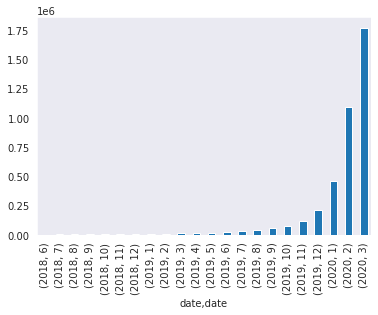

In [ ]:
posts_df[posts_df['date'] > datetime.now() - timedelta(days=700)].groupby(
    [posts_df["date"].dt.year, posts_df["date"].dt.month]
  ).id.count().plot(kind="bar")

In [ ]:
posts_df['date'].min(), posts_df['date'].max()

(Timestamp('2007-06-05 17:45:00'), Timestamp('2020-03-17 17:09:23'))

In [ ]:
posts_df.groupby(
    [posts_df["date"].dt.year]
  ).id.count().reset_index(name='count').set_index('date').transpose()

date,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,19,2,8,37,496,304,497,1619,1332,4365,9292,34102,603337,3319746


In [ ]:
df = posts_df[posts_df['date'] > datetime(2020, 1, 1, 0, 0)].groupby(
    [posts_df["date"].dt.year, posts_df["date"].dt.month, posts_df["date"].dt.day]
).id.count()

df.index.names = ['year', 'month', 'day']

df.reset_index(name='count').set_index(['year', 'month', 'day']).transpose()

year   2020                              ...                                       
month     1                              ...       3                               
day      1      2      3      4      5   ...      13      14      15      16     17
count  8534  10314  10735  10446  10454  ...  136477  143342  167112  188435  43093

[1 rows x 77 columns]

## Check missing values

In [ ]:
posts_df.isna().apply(pd.value_counts).fillna(0)

,id,title,selftext,created_utc,subreddit_id,subreddit_name,date
False,3975156.0,3975151,1990863,3975156.0,3975156.0,3975156.0,3975156.0
True,0.0,5,1984293,0.0,0.0,0.0,0.0


## Check duplicated titles

In [ ]:
posts_df.groupby(
    ['title', 'subreddit_name']
).size().sort_values(
    ascending=False
).head(20)

title                      subreddit_name      
Is Today Friday the 13th?  IsTodayFridayThe13th    996
hmmm                       hmmm                    992
2meirl4meirl               2meirl4meirl            823
Maybe Maybe Maybe          maybemaybemaybe         721
anime_irl                  anime_irl               677
absolutelynotme_irl        absolutelynotme_irl     586
egg_irl                    egg_irl                 502
meirl                      meirl                   402
Woof_irl                   woof_irl                385
me_irl                     me_irl                  353
ik_ihe                     ik_ihe                  306
Meirl                      meirl                   278
ich_iel                    ich_iel                 273
Me_irl                     me_irl                  267
Ik_ihe                     ik_ihe                  265
Egg_irl                    egg_irl                 254
woof_irl                   woof_irl                251
Absolutelynotme_i

## Get number of posts per subreddit distribution

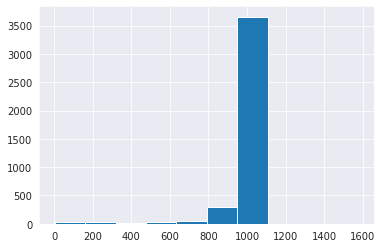

In [ ]:
posts_df.groupby(
    'subreddit_name'
).size().hist()

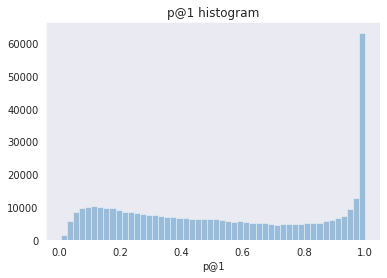

In [ ]:
sns.distplot(
    predictions_df['p@1'], kde=False
).set_title('p@1 histogram')

plt.show()

# Get precision, recall, f1-score for each subreddit

In [ ]:
report_df = pd.DataFrame(classification_report(
    predictions_df['label'],
    predictions_df['label@1'],
    output_dict=True,
    zero_division=0
)).transpose().reset_index().rename(
    columns={'index': 'subreddit'}
)

report_df.to_csv('classification_report_by_subreddit.csv', index=False)

report_df.sort_values('f1-score', ascending=False).head(300)

,subreddit,precision,recall,f1-score,support
4083,woof_irl,1.000000,1.000000,1.000000,109.0
1014,IsTodayFridayThe13th,0.991304,1.000000,0.995633,114.0
2167,anime_irl,0.989474,1.000000,0.994709,94.0
2920,holdmyfries,1.000000,0.986842,0.993377,76.0
2242,autotldr,0.989362,0.989362,0.989362,94.0
...,...,...,...,...,...
3068,koreanvariety,0.679612,0.760870,0.717949,92.0
2154,amazon,0.694737,0.741573,0.717391,89.0
227,Barca,0.693333,0.742857,0.717241,70.0
111,Animal_Sanctuary,0.724490,0.710000,0.717172,100.0


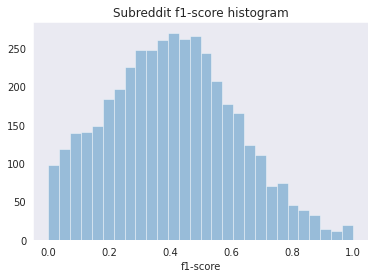

In [ ]:
sns.distplot(
    report_df['f1-score'], kde=False
).set_title('Subreddit f1-score histogram')

plt.show()

# Get confusion matrix in long format

In [ ]:
cm = predictions_df.groupby(
    ['label', 'label@1']
).size().sort_values(ascending=False).reset_index(name='count')

cm[cm['count'] > 1].to_csv('confusion_matrix_gt2.csv')

cm[cm['label'] != cm['label@1']].head(10)

,label,label@1,count
125,ModelsGoneMild,ClassyPornstars,83
1292,bipolar,BipolarReddit,50
1328,carnivore,zerocarb,49
1474,Needafriend,MakeNewFriendsHere,47
1512,me_irl,meirl,46
1567,qBittorrent,torrents,46
1801,FreeGamesOnSteam,FreeGameFindings,42
1961,SwitchHaxing,SwitchHacks,40
2041,SSAwakening,SaintSeiyaKOTZ,39
2073,PAXvapor,ploompax,39


# Get metrics distribution by probability

In [ ]:
p_f1_df = predictions_df.assign(
    p=lambda x: x['p@1'].apply(lambda x: round(x, 2))
).groupby('p').apply(
    lambda x: f1_score(x['label'], x['label@1'], average='micro')
).reset_index(name='f1_score').rename(columns={'p': 'p@1'})

In [ ]:
sns.lineplot(
    x=p_f1_df['p@1'], y=p_f1_df['f1_score']
).set_title('p@1 vs f1-score')

sns.lineplot(x=[0, 1], y=[0, 1], lw=1, color="grey")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

# Get precision@k, recall@k, f1-score@k for all k={1...20}